In [29]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"

opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [30]:
!rm -rf /kaggle/working/results/checkpoint-*
!rm -rf /kaggle/working/logs/*


In [31]:
!pip install torch torchvision transformers opencv-python scikit-learn

In [32]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


In [33]:
# Define the transformations for the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torchvision import transforms
from PIL import Image
import os

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")

# Verify column names
print(df.columns)

# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['level', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)

Index([' id', 'caption', 'label', 'level', 'area', 'Unnamed: 5'], dtype='object')


In [35]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, images_folder, image_transforms):
        # Filter out 'non informative' rows
        self.dataframe = dataframe[dataframe['label'].str.lower().str.strip() != 'non informative'].reset_index(drop=True)
        self.images_folder = images_folder
        self.image_transforms = image_transforms

        self.class_to_index = {
            'flood': 0,
            'cyclone': 1,
            'earthquake': 2,
            'river erosion': 3,
            'anthropogenic': 4
        }

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        label = row['label']
        image_id = str(row[' id']).strip()  # Adjust key if needed

        # Convert string label to int
        if isinstance(label, str):
            label = self.class_to_index[label.lower().strip()]
        else:
            label = int(label)

        # Check file extensions
        image_path_jpg = os.path.join(self.images_folder, f"{image_id}.jpg")
        image_path_png = os.path.join(self.images_folder, f"{image_id}.png")
        image_path_jpeg = os.path.join(self.images_folder, f"{image_id}.jpeg")

        if os.path.exists(image_path_jpg):
            image_path = image_path_jpg
        elif os.path.exists(image_path_png):
            image_path = image_path_png
        elif os.path.exists(image_path_jpeg):
            image_path = image_path_jpeg
        else:
            raise FileNotFoundError(f"Image {image_id} not found with .jpg, .png or .jpeg extension")

        image = Image.open(image_path).convert('RGB')
        image = self.image_transforms(image)

        assert 0 <= label <= 4, f"Label {label} out of range"

        return {
            'original_label': label,
            'pixel_values': image,
            'label': torch.tensor(label, dtype=torch.long)
        }

# Utility to show image
def imshow(image, ax=None, title=None, normalize=False):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')
    return ax

# Utility to print samples
def print_samples(dataloader, num_samples=5):
    count = 0
    for batch in dataloader:
        if count >= num_samples:
            break
        for i in range(len(batch['pixel_values'])):
            if count >= num_samples:
                break
            print(f"Sample {count+1}:")
            print(f"Original Label: {batch['original_label'][i]}")
            imshow(batch['pixel_values'][i], normalize=True)
            plt.show()
            print()
            count += 1

In [36]:
# Data augmentation and normalization transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [37]:
# Paths
images_folder = '/kaggle/input/mddb-images/Photos_Final'

# Dataset and loaders (make sure train_data, valid_data, test_data DataFrames exist)
train_dataset = ImageDataset(train_data, images_folder, train_transforms)
valid_dataset = ImageDataset(valid_data, images_folder, valid_transforms)
test_dataset = ImageDataset(test_data, images_folder, valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


In [38]:
import torchvision
print(torchvision.__version__)


0.20.1+cu121


In [39]:
# Model setup
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Replace the classifier's final layer for 5 classes
model.classifier[6] = nn.Linear(4096, 5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

# Training function
def train_one_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0

    for batch in data_loader:
        optimizer.zero_grad()
        inputs = batch['pixel_values'].to(device)
        labels = batch['label'].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

# Validation function
def validate_one_epoch(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = correct_predictions.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

# Early stopping parameters
num_epochs = 20
best_acc = 0.0
patience = 5
counter = 0

# Lists to save loss and accuracy for plotting
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Training loop
for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    valid_loss, valid_acc = validate_one_epoch(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc.item())
    valid_accuracies.append(valid_acc.item())

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')

    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), 'best_model.pth')
        counter = 0
        print(f'Validation accuracy improved to {best_acc:.4f}. Model saved.')
    else:
        counter += 1
        print(f'No improvement for {counter} epoch(s)')

    if counter >= patience:
        print(f'Early stopping triggered after {patience} epochs with no improvement.')
        break

print('Training complete')

Epoch 1/20
Train Loss: 1.4507 | Train Acc: 0.3646
Valid Loss: 1.1184 | Valid Acc: 0.5762
Validation accuracy improved to 0.5762. Model saved.
Epoch 2/20
Train Loss: 1.1408 | Train Acc: 0.5466
Valid Loss: 0.9196 | Valid Acc: 0.6636
Validation accuracy improved to 0.6636. Model saved.
Epoch 3/20
Train Loss: 0.9999 | Train Acc: 0.6083
Valid Loss: 0.8584 | Valid Acc: 0.6450
No improvement for 1 epoch(s)
Epoch 4/20
Train Loss: 0.8954 | Train Acc: 0.6455
Valid Loss: 0.7740 | Valid Acc: 0.7045
Validation accuracy improved to 0.7045. Model saved.
Epoch 5/20
Train Loss: 0.8471 | Train Acc: 0.6788
Valid Loss: 0.7694 | Valid Acc: 0.7100
Validation accuracy improved to 0.7100. Model saved.
Epoch 6/20
Train Loss: 0.7919 | Train Acc: 0.6908
Valid Loss: 0.7362 | Valid Acc: 0.7100
No improvement for 1 epoch(s)
Epoch 7/20
Train Loss: 0.7447 | Train Acc: 0.7179
Valid Loss: 0.7733 | Valid Acc: 0.6970
No improvement for 2 epoch(s)
Epoch 8/20
Train Loss: 0.7325 | Train Acc: 0.7217
Valid Loss: 0.7131 | Vali

<ipython-input-40-cc2d7045082f>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Accuracy: 0.7290
Precision: 0.7427
Recall: 0.7290
F1 Score: 0.7314

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       106
           1       0.58      0.62      0.60       101
           2       0.65      0.78      0.71        89
           3       0.74      0.80      0.77        97
           4       0.89      0.70      0.78       142

    accuracy                           0.73       535
   macro avg       0.73      0.73      0.73       535
weighted avg       0.74      0.73      0.73       535



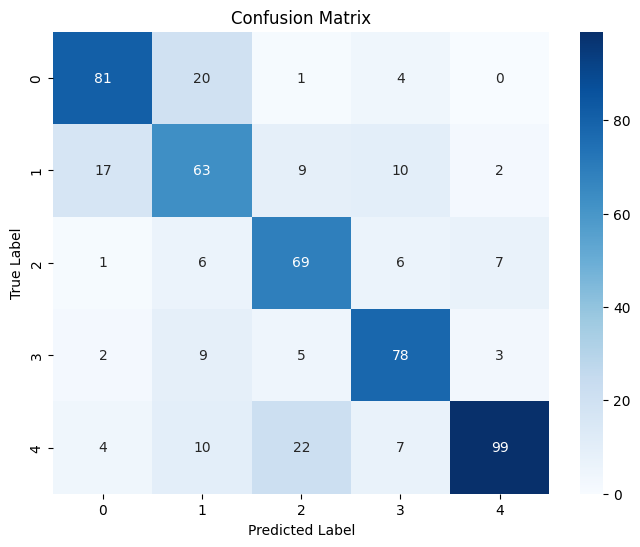

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

# Predictions
def predict(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['pixel_values'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    return predictions

test_predictions = predict(model, test_loader, device)

# Evaluation
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['pixel_values'].to(device)
            labels = batch['label'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds)

    return accuracy, precision, recall, f1, report, all_labels, all_preds

accuracy, precision, recall, f1, report, all_labels, all_preds = evaluate_model(model, test_loader, device)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(5), yticklabels=range(5))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

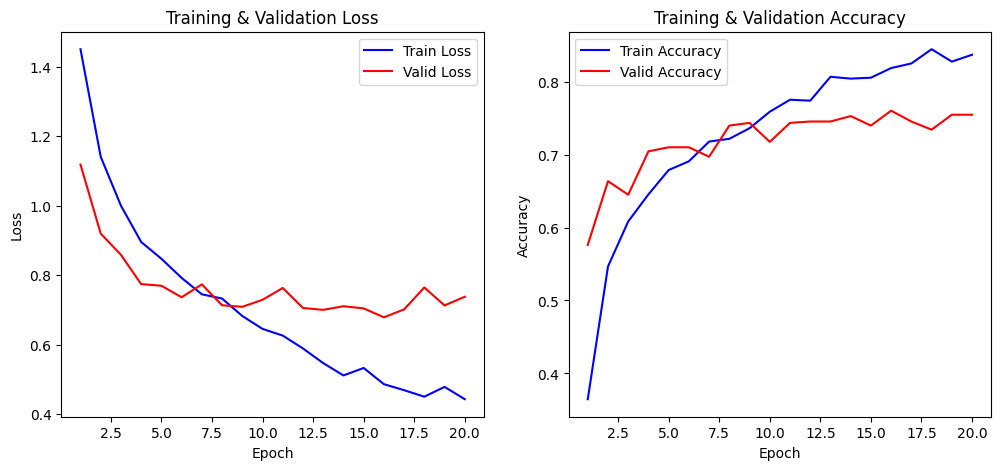

In [41]:
# Plot training & validation loss and accuracy curves
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b-', label='Train Loss')
plt.plot(epochs, valid_losses, 'r-', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b-', label='Train Accuracy')
plt.plot(epochs, valid_accuracies, 'r-', label='Valid Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()